In [23]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 
import os

# For processing
import math
import random
import datetime as dt

# Libraries for model training
!pip install scikit-learn
!pip install tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [24]:
df = pd.read_csv("CAC40_stocks_2010_2021.csv", parse_dates=['Date'])
df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
0,TechnipFMC,FTI,29.855000,29.075001,29.075001,29.615000,1908400.0,2010-01-04
1,TechnipFMC,FTI,30.270000,29.555000,29.610001,30.125000,2206600.0,2010-01-05
2,TechnipFMC,FTI,30.305000,29.434999,30.040001,30.264999,2724200.0,2010-01-06
3,TechnipFMC,FTI,30.219999,29.715000,30.155001,29.915001,2581000.0,2010-01-07
4,TechnipFMC,FTI,30.500000,29.625000,29.830000,30.450001,3280400.0,2010-01-08


In [25]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81735 entries, 0 to 81734
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CompanyName  81735 non-null  object        
 1   StockName    81735 non-null  object        
 2   High         81735 non-null  float64       
 3   Low          81735 non-null  float64       
 4   Open         81735 non-null  float64       
 5   Close        81735 non-null  float64       
 6   Volume       81735 non-null  float64       
 7   Date         81735 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 5.0+ MB


In [26]:
# Defining a function that will contain stocks data for a specific company
def specific_data(company, start, end):
    company_data = df[df['CompanyName'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

# Selecting any random company out of our 'CompanyName' column
company_name = random.choice(df['CompanyName'].unique().tolist())
# Setting the start and end date
start_date=dt.datetime(2014,1,1)
end_date=dt.datetime(2020,1,1)

# Calling our function
specific_df = specific_data(company_name, start_date, end_date)

specific_df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
3795,Atos,ATO,45.520000,44.450001,45.340000,44.669998,422000.0,2014-01-02
3796,Atos,ATO,45.000000,44.400002,44.619999,44.740002,647300.0,2014-01-03
3797,Atos,ATO,44.740002,44.160000,44.709999,44.189999,298700.0,2014-01-06
3798,Atos,ATO,45.509998,44.299999,44.400002,45.180000,460500.0,2014-01-07
3799,Atos,ATO,45.509998,44.919998,45.270000,45.419998,568600.0,2014-01-08


Visualization

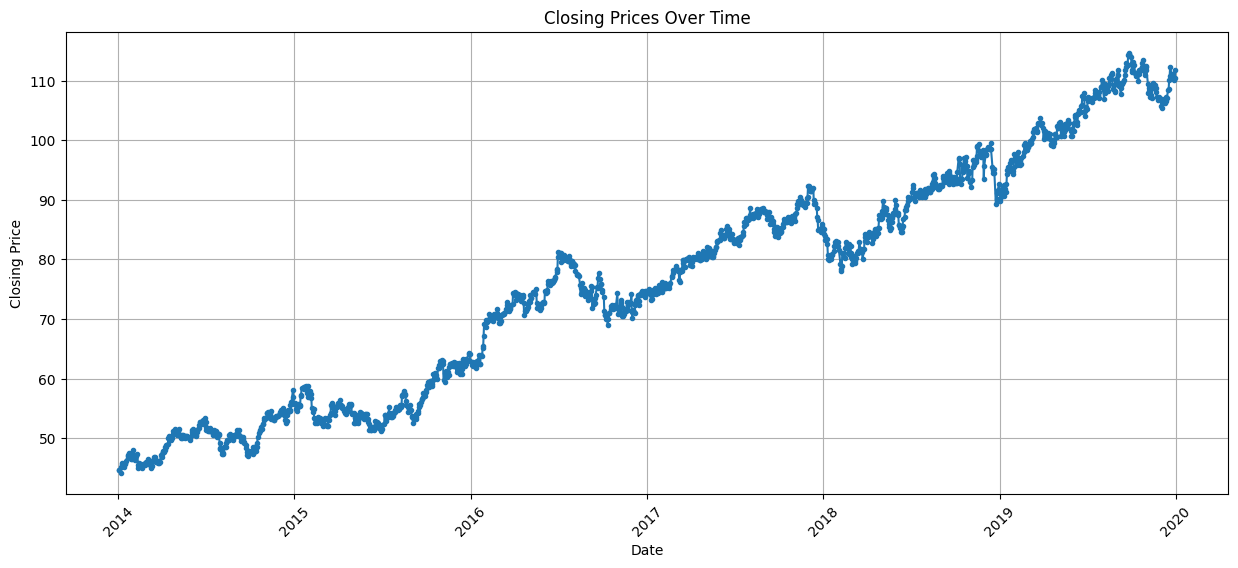

In [27]:
import matplotlib.pyplot as plt
# Line Chart of Closing Prices Over Time

# Convert 'Date' column to datetime
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

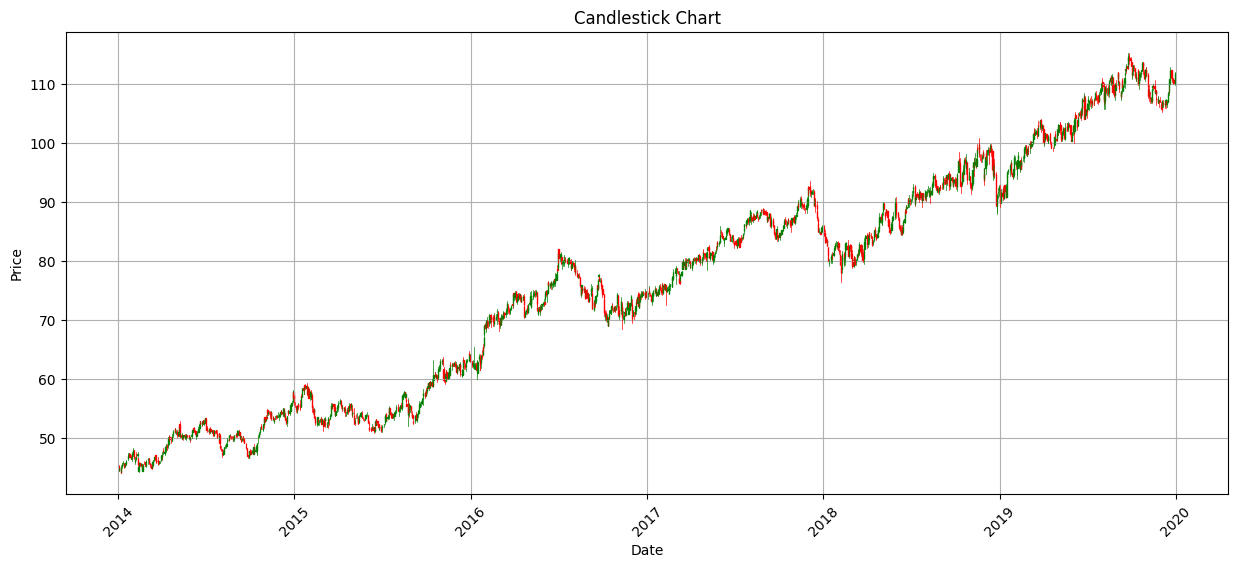

In [28]:
# Candlestick Chart
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# Convert 'Date' column to matplotlib date format
matplotlib_date = mdates.date2num(specific_df['Date'])

# Create an array of tuples in the required format
ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

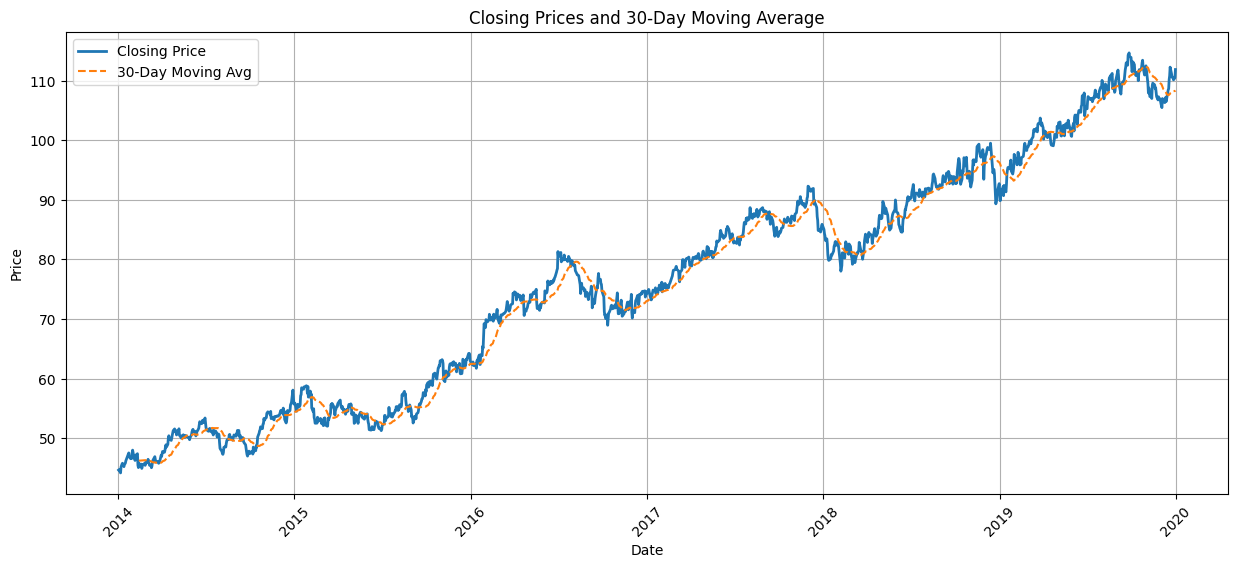

In [29]:
# Closing Prices and Moving Average plot

window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(), label=f'{window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

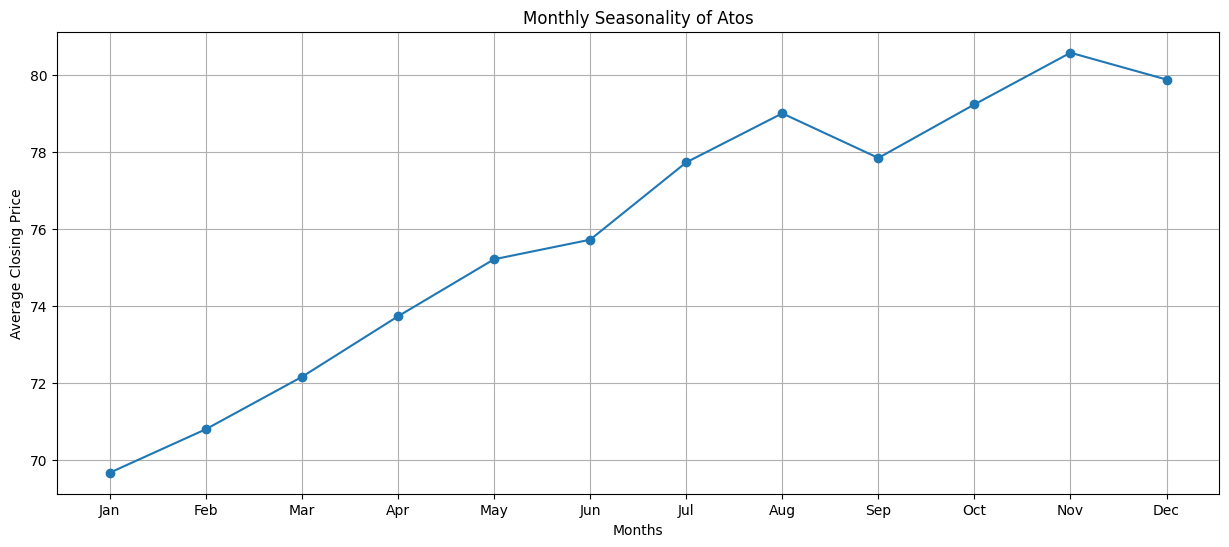

In [30]:
# Monthly Seasonality of Closing Prices
specific_df['Month'] = specific_df['Date'].dt.month

monthly_average = specific_df.groupby('Month')['Close'].mean()

plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title(f'Monthly Seasonality of {company_name}')
plt.xlabel('Months')
plt.ylabel('Average Closing Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [31]:
new_df = specific_df.reset_index()['Close']
new_df

0        44.669998
1        44.740002
2        44.189999
3        45.180000
4        45.419998
           ...    
1505    110.580002
1506    110.500000
1507    110.129997
1508    110.470001
1509    111.860001
Name: Close, Length: 1510, dtype: float64

In [32]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [33]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [34]:
# Define the sequence length (number of past time steps)
n_past = 60

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [35]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1148, 60)
(1148,)


Testing set size:-
(242, 60)
(242,)


(None, None)

In [36]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Model training

In [37]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))         # Adding dropout to prevent overfitting

# Second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# Defining our callbacks
checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
# Defining our early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training our lstm model
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0597 - val_loss: 0.0242
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0021 - val_loss: 5.5266e-04
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [40]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [41]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

72.27435402282467
104.55805656179828


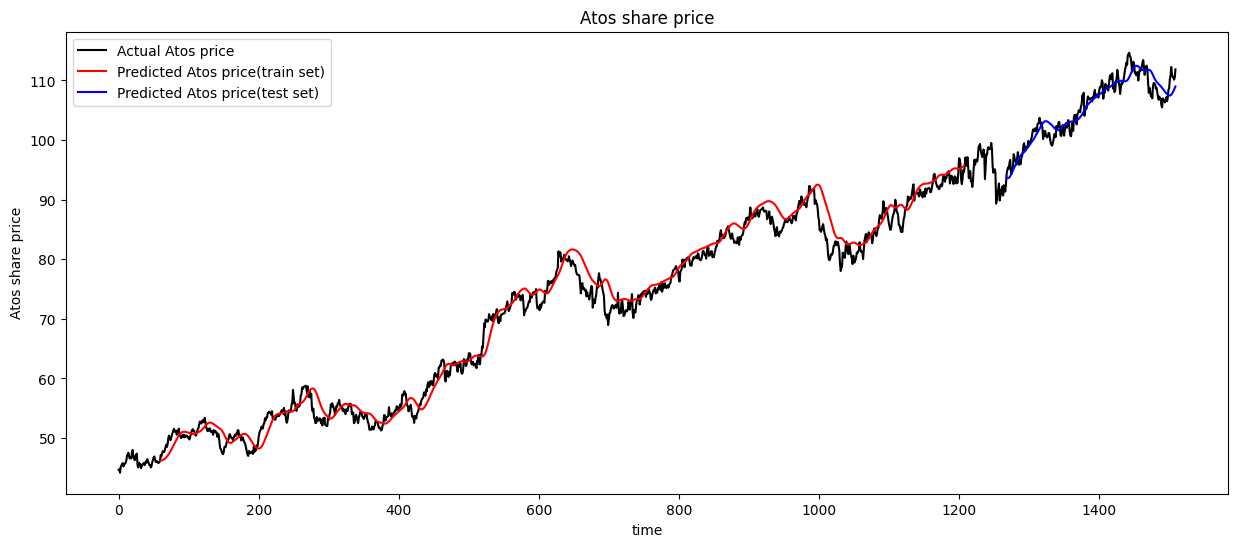

In [42]:
look_back = 60
trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()
testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()
original_scaled_data = scaler.inverse_transform(scaled_data)
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {company_name} price(test set)")

plt.title(f"{company_name} share price")
plt.xlabel("time")
plt.ylabel(f"{company_name} share price")
plt.legend()
plt.show()

In [43]:
last_sequence = X_test[-1]

last_sequence = last_sequence.reshape(1, n_past, 1)
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 108.98056030273438
Day 2: Predicted Price = 109.21271514892578
Day 3: Predicted Price = 109.40998077392578
Day 4: Predicted Price = 109.570068359375
Day 5: Predicted Price = 109.69519805908203
Day 6: Predicted Price = 109.78997802734375
Day 7: Predicted Price = 109.86009979248047
Day 8: Predicted Price = 109.91130065917969
Day 9: Predicted Price = 109.9487075805664
Day 10: Predicted Price = 109.97660064697266


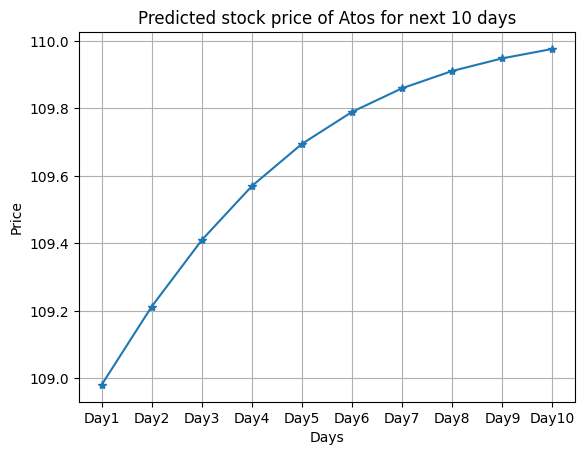

In [44]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of {company_name} for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()